In [ ]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

def load_environment_data():
    """
    Loads fixed place cell, reward cell network data, environment data, and dynamically discovers scale files.

    Returns:
    - data (dict): A dictionary containing loaded network data, environment data, and scale files.
    """
    data = {}

    # Load place cell and reward cell network data
    try:
        with open('pcn.pkl', 'rb') as f:
            data['pc_net'] = pickle.load(f)
        with open('rcn.pkl', 'rb') as f:
            data['rc_net'] = pickle.load(f)
    except FileNotFoundError as e:
        print(f"Error loading network files: {e}")
        return None

    # Load environment data (place cell and reward map coordinates)
    try:
        with open('hmap_x.pkl', 'rb') as f:
            data['hmap_x'] = pickle.load(f)
            print("loaded hmap_x")
        with open('hmap_y.pkl', 'rb') as f:
            data['hmap_y'] = pickle.load(f)
            print("loaded hmap_y")
        with open('hmap_g.pkl', 'rb') as f:
            data['hmap_g'] = np.asarray(pickle.load(f))
            print("loaded hmap_g")
        with open('hmap_vis_density.pkl', 'rb') as f:
            data['hmap_vis_density'] = np.asarray(pickle.load(f))
            print("loaded hmap_vis_density")
    except FileNotFoundError as e:
        print(f"Error loading environment data files: {e}")
        return None

    # Set goal properties
    data['goal_r'] = 0.3  # Goal radius
    data['goal_location'] = [-1, 1]  # Goal location

    # Dynamically load hmap_z_scale_{index}.pkl files
    data['hmap_z_scales'] = []
    for file in sorted(os.listdir(".")):
        if file.startswith("hmap_z_scale_") and file.endswith(".pkl"):
            try:
                with open(file, 'rb') as f:
                    data['hmap_z_scales'].append(pickle.load(f))
                    print(f"loaded {file}")
            except Exception as e:
                print(f"Error loading {file}: {e}")

    if not data['hmap_z_scales']:
        print("No hmap_z_scale_{index}.pkl files found in the current directory.")

    return data


data = load_environment_data()

Top 10 place cells for scale 0: [118 122 127  87  55  71 121  28  98  81]


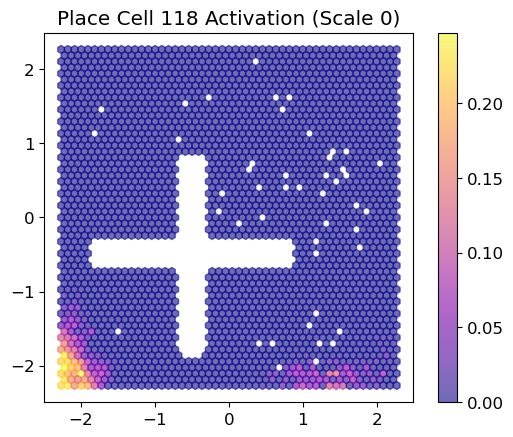

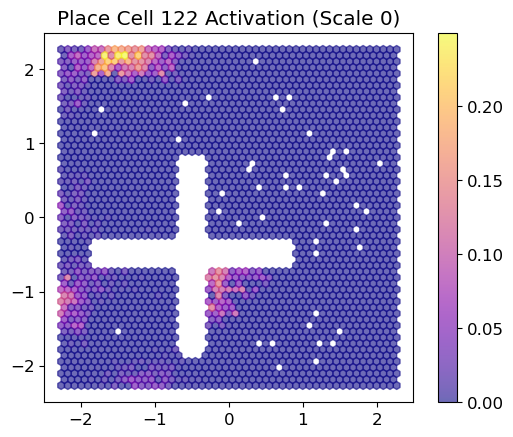

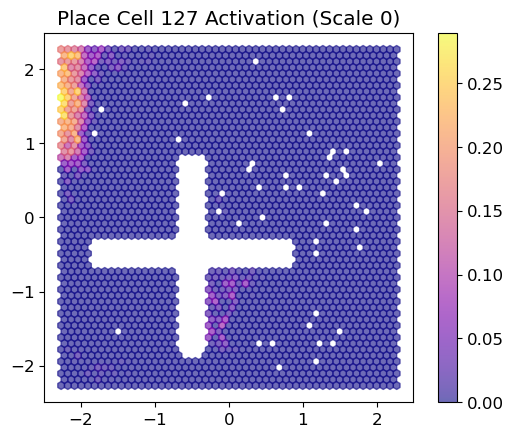

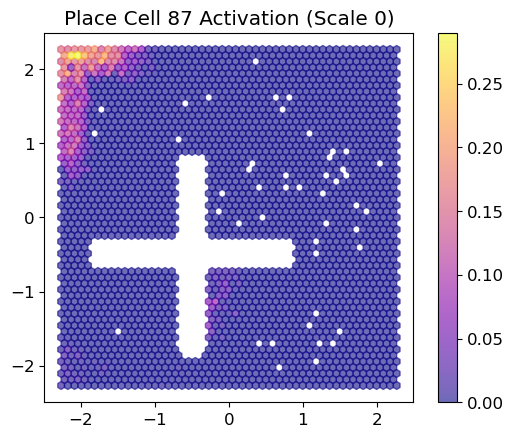

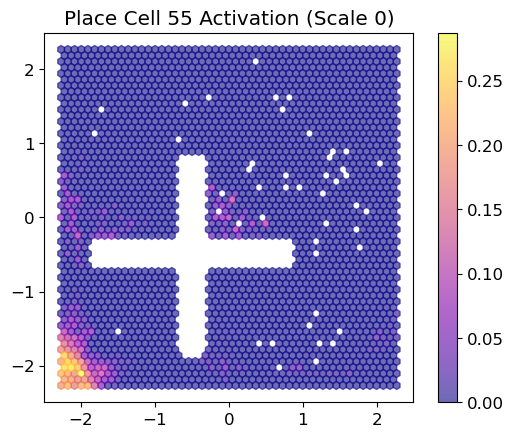

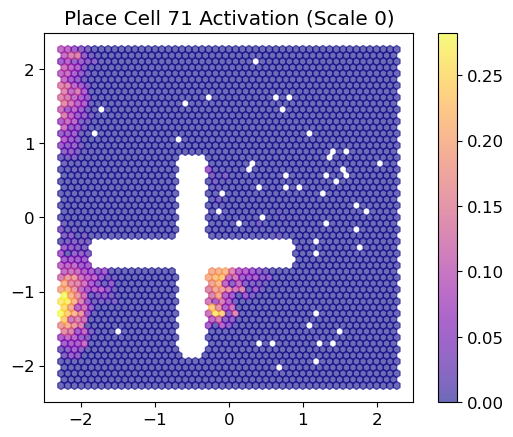

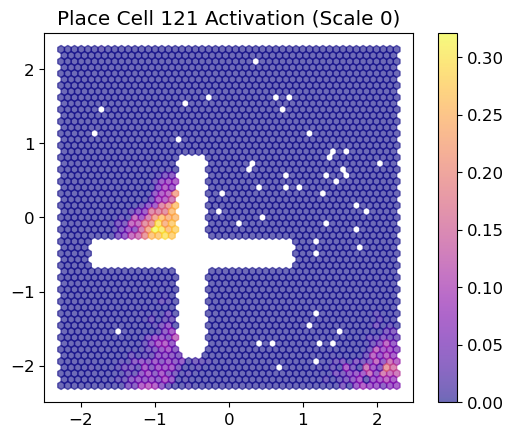

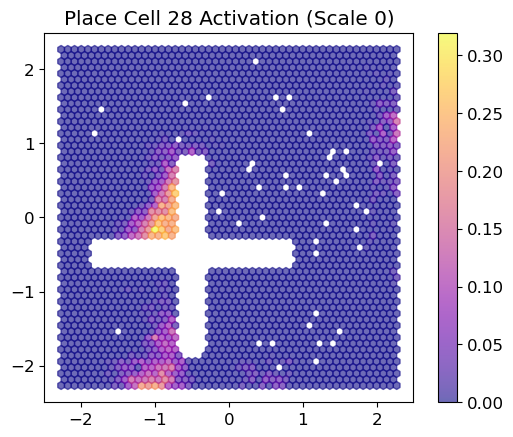

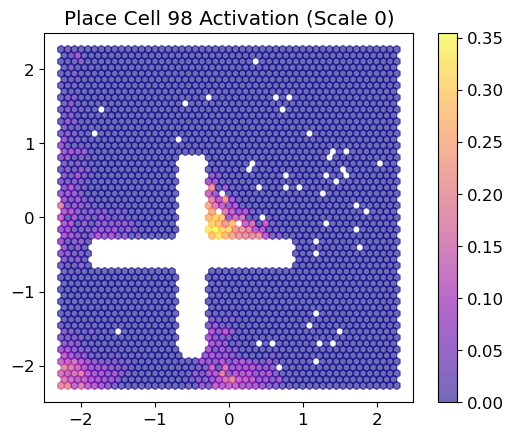

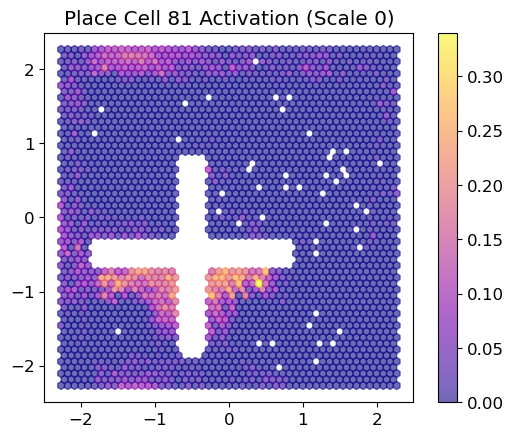

Top 10 place cells for scale 1: [42 38 30 49  6 28  3 41 32 39]


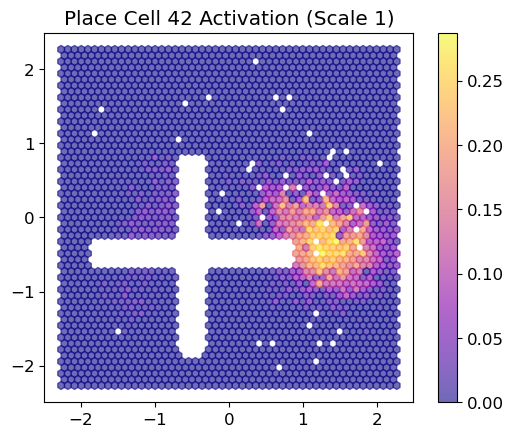

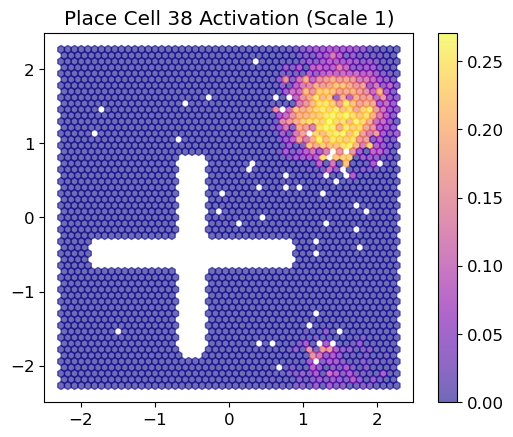

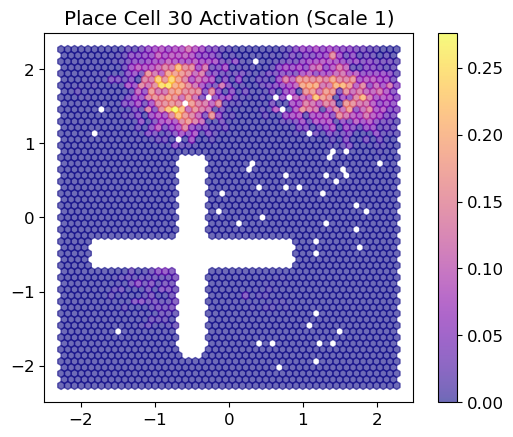

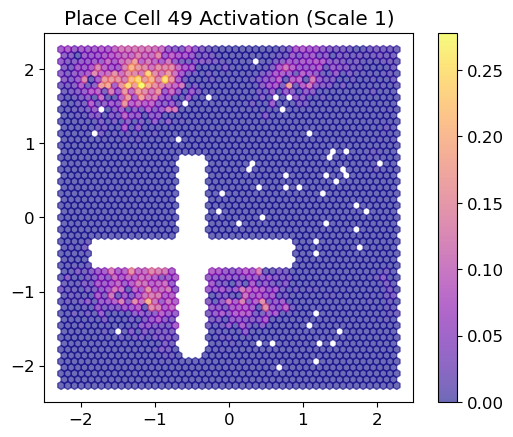

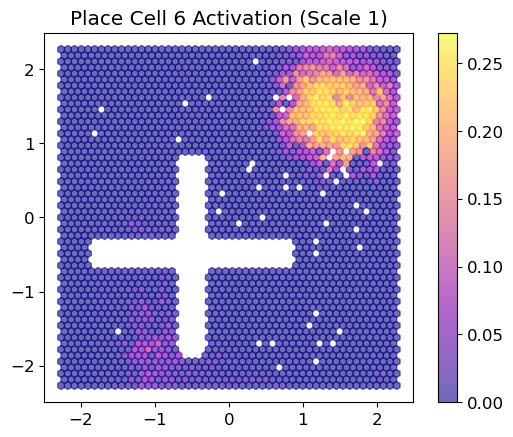

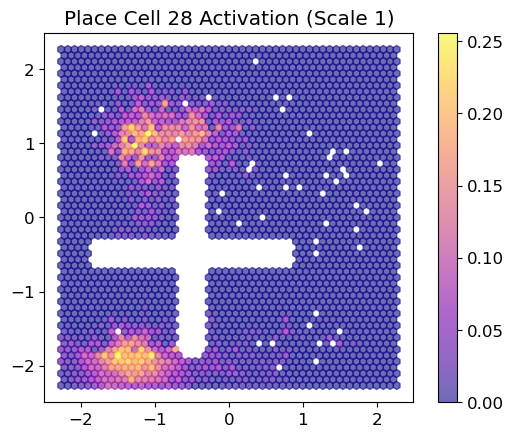

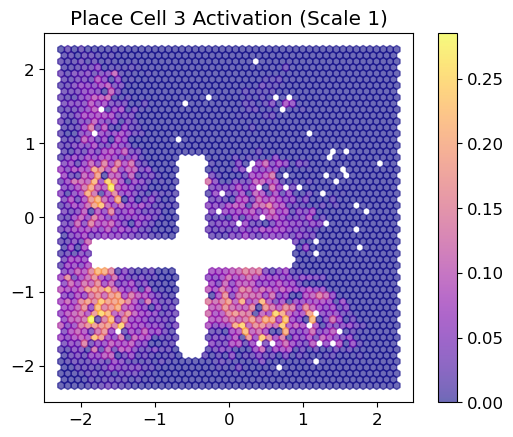

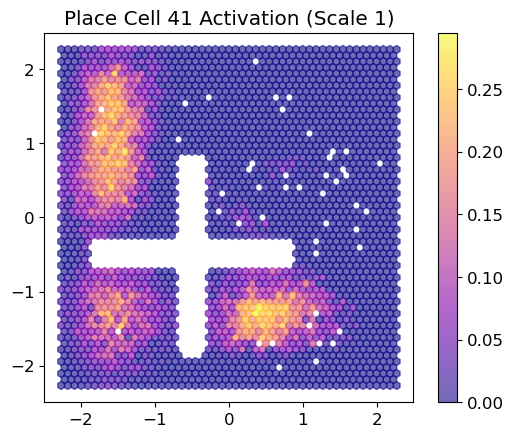

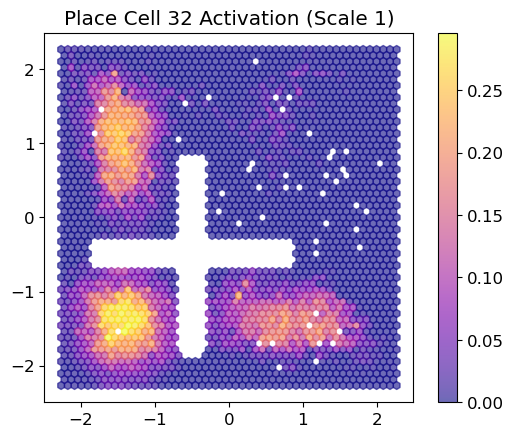

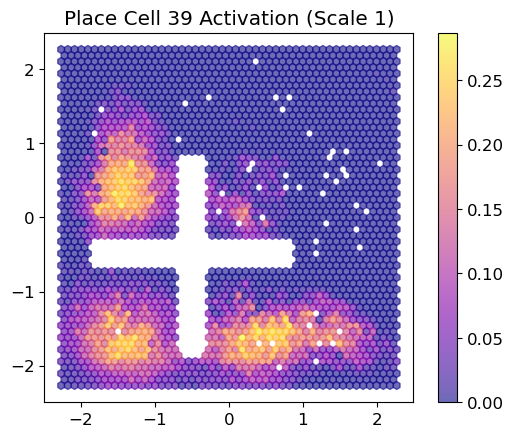

In [35]:
def probeOne(probed, scale_index, data):
    """
    Visualizes the activation of a specific place cell (probed) over the environment map.

    Parameters:
    - probed (int): The index of the place cell to visualize.
    - scale_index (int): The index of the scale to use from the loaded data.
    - data (dict): The loaded environment data, including hmap_x, hmap_y, and hmap_z_scales.
    """
    hmap_x = data['hmap_x']
    hmap_y = data['hmap_y']
    hmap_z_scales = data['hmap_z_scales']

    if scale_index >= len(hmap_z_scales):
        raise ValueError(f"Scale index {scale_index} is out of range. Available scales: {len(hmap_z_scales)}")

    activations = hmap_z_scales[scale_index][:, probed]

    # Plot the activations
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")

    # Create a hexbin plot for place cell activations
    cntr = ax.hexbin(hmap_x, hmap_y, activations, gridsize=50, cmap=cmap, alpha=0.6)

    # Add colorbar and title
    plt.colorbar(cntr)
    plt.title(f"Place Cell {probed} Activation (Scale {scale_index})")
    plt.show()

# Calculate the total activation for each scale
total_activations_by_scale = [np.sum(hmap_z, axis=0) for hmap_z in data['hmap_z_scales']]

# Get the indices of the top 10 most activated place cells for each scale
top_cells_by_scale = [
    np.argsort(total_activations)[-10:] for total_activations in total_activations_by_scale
]

# Plot the activations for the top 10 place cells in each scale
for scale_index, top_cells in enumerate(top_cells_by_scale):
    print(f"Top 10 place cells for scale {scale_index}: {top_cells}")
    for cell in top_cells:
        probeOne(cell, scale_index, data)


C:\Users\bduke\AppData\Local\Temp\ipykernel_26900\3273028055.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("plasma")  # Use the plasma colormap


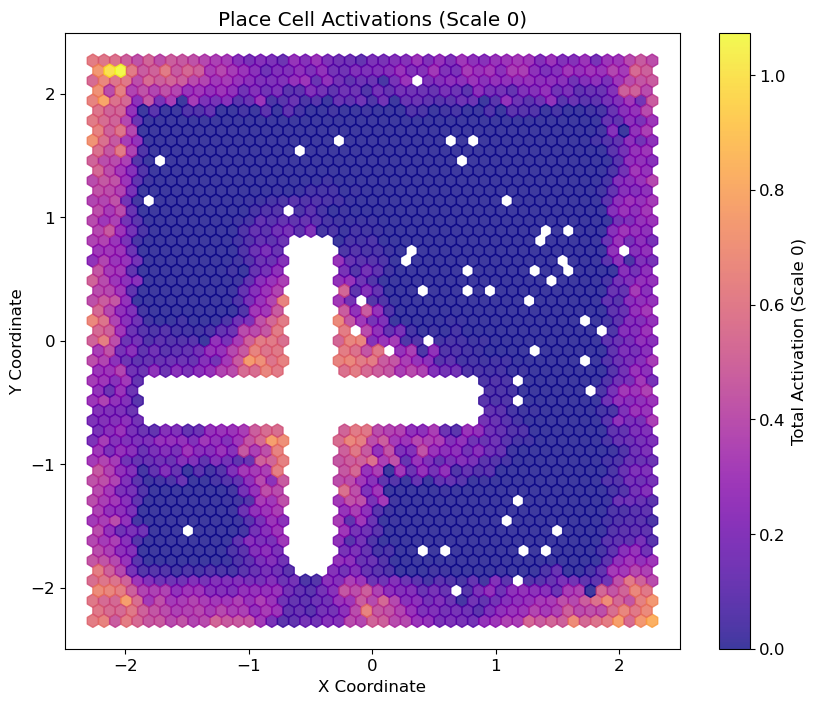

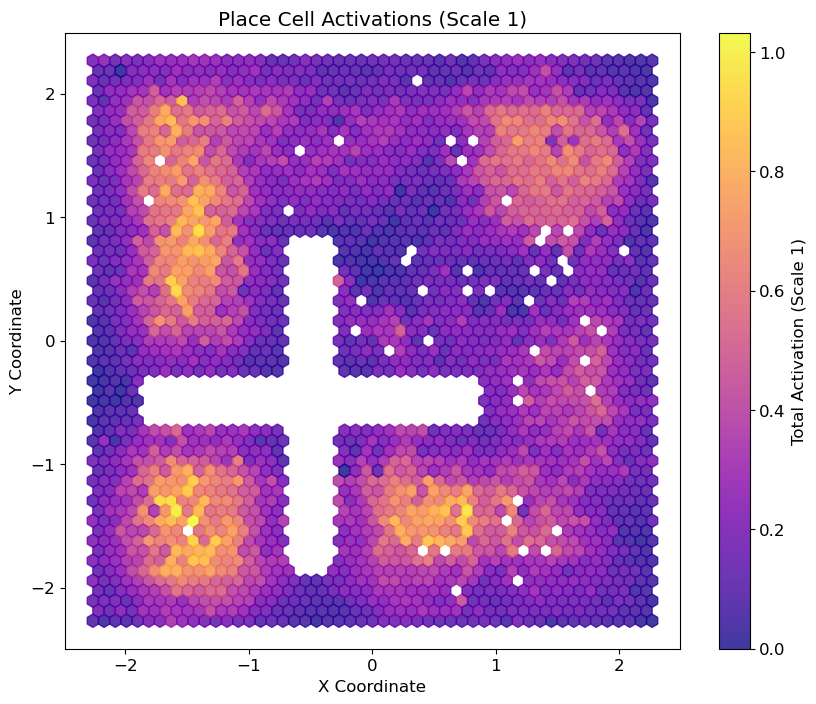

In [ ]:
def plot_overlaid_pcn_activations(data):
    """
    Plots the place cell activations for all scales in the provided data.

    Parameters:
    - data (dict): A dictionary containing hmap_x, hmap_y, and a list of hmap_z_scales.
    """
    hmap_x = data['hmap_x']
    hmap_y = data['hmap_y']
    hmap_z_scales = data['hmap_z_scales']

    cmap = get_cmap("plasma")  # Use the plasma colormap

    for i, hmap_z in enumerate(hmap_z_scales):
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.set_aspect("equal")
        ax.set_title(f"Aggregate Place Cell Activations (Scale {i})")
        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")

        # Compute and plot activations for the current scale
        total_activation = np.sum(hmap_z, axis=1)
        hb = ax.hexbin(
            hmap_x,
            hmap_y,
            total_activation,
            gridsize=50,
            cmap=cmap,
            reduce_C_function=np.mean,
            alpha=0.8,
        )

        # Add colorbar and labels
        cb = plt.colorbar(hb, ax=ax)
        cb.set_label(f"Total Activation")

        plt.show()

plot_overlaid_pcn_activations(data)

In [ ]:
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

def plot_rcn_activation(context=0):
    """
    Visualizes the reward cell activations across the environment.

    Parameters:
    context (int): Context index for the reward cell weights.
    """
    # Load the RCN layer (reward cell network)
    with open('rcn.pkl', 'rb') as f:
        rc_net = pickle.load(f)

    # Compute the total place cell activations to use in normalizing the reward activations
    sum_activations = tf.reduce_sum(hmap_z, axis=-1)
    safe_denominator = tf.where(sum_activations > 0, sum_activations, 1)  # Avoid division by zero

    # Ensure that both tensors are float32 for tensordot and division
    hmap_z_float32 = tf.cast(hmap_z.T, tf.float32)  # Transpose and cast hmap_z to float32
    w_in_effective_float32 = tf.cast(rc_net.w_in_effective, tf.float32)  # Cast rc_net effective weights to float32
    safe_denominator = tf.cast(safe_denominator, tf.float32)  # Cast safe_denominator to float32

    # Compute the reward function using the RCN effective weights and the place cell activations
    reward_function = tf.tensordot(w_in_effective_float32[context], hmap_z_float32, axes=1) / safe_denominator

    # Flatten reward function to ensure it's a 1D array
    reward_function = tf.squeeze(reward_function)

    # Check if reward_function has the same shape as hmap_x and hmap_y
    if reward_function.shape != hmap_x.shape:
        raise ValueError(f"Shape mismatch: reward_function has shape {reward_function.shape}, but expected {hmap_x.shape}.")

    # Plot the reward function over the environment
    fig, ax = plt.subplots(dpi=150)
    ax.set_aspect('equal')

    # Create a hexbin plot for the reward activations
    cntr = ax.hexbin(hmap_x, hmap_y, reward_function.numpy(), gridsize=50, cmap=cmap, alpha=0.6)

    # Rotate the plot by 180 degrees by reversing the x and y limits
    ax.set_ylim(5, -5)
    ax.set_xlim(5, -5)
    ax.set_axis_off()

    # Increase the size of the map relative to the overall plot
    fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

    # Draw the goal location as a green circle
    goal = plt.Circle(goalLocation, goal_r, color='green', alpha=0.5, fill=True)
    ax.add_patch(goal)

    # Add a colorbar for the reward values
    fig.colorbar(cntr)
    plt.title(f"Reward Map Visualization for context {context}")
    plt.show()

# Call the function with a specific context
#plot_rcn_activation(context=0)


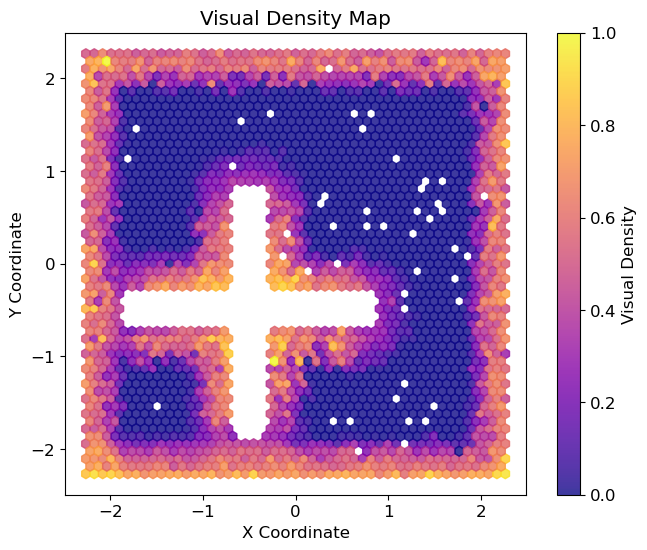

In [ ]:
def plot_vis_density(hmap_x, hmap_y, hmap_vis_density):
    """
    Visualizes the visual density over the environment map using hexbin plotting.

    Parameters:
    - hmap_x (np.ndarray): X-coordinates of the robot's trajectory.
    - hmap_y (np.ndarray): Y-coordinates of the robot's trajectory.
    - hmap_vis_density (np.ndarray): Visual density values at each step.
    """
    # Set up the plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")
    ax.set_title("Visual Density Map")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")

    # Create a hexbin plot for visual density
    hb = ax.hexbin(
        hmap_x, hmap_y, hmap_vis_density, gridsize=50, cmap=cmap, reduce_C_function=np.mean, alpha=0.8
    )

    # Add colorbar and labels
    cb = plt.colorbar(hb, ax=ax)
    cb.set_label("Visual Density")
    
    # Show the plot
    plt.show()

plot_vis_density(hmap_x, hmap_y, hmap_vis_density)